# Warming Stripes

Let's create our own figure of "[warming stripes](https://en.wikipedia.org/wiki/Warming_stripes)" that use a red/blue color scale to represent annual air temperature deviations from some climate mean tempearture over a long timeseries. This notebook is based on, and adapts code from ["Creating the Warming Stripes in Matplotlib" by Maximilian Nöthe](https://matplotlib.org/matplotblog/posts/warming-stripes/).

We will use air temperature from [NASA's DayMet dataset](https://daymet.ornl.gov/), and access it through an API using the [ulmo](https://github.com/ulmo-dev/ulmo/) python package.

Since we don't have ulmo installed on our JupyterHub by default, the first time you run this notebook, you'll need to install the ulmo package into our python envrionment.

**Run the cell below once.** Uncomment it now, so that it reads `!pip install ulmo`, and run it. It will install ulmo on your JupyterHub. You shouldn't need to re-run it next time you open this notebook, so it's best to comment it out again when it completes.

When it is complete and you've commented it back out, restart the kernel by going to *Kernel* > *Restart Kernel*.

In [ ]:
#!pip install ulmo

---

In [2]:
# packages for working with our data
import pandas as pd
import numpy as np

# page we'll use to access the data
import ulmo

# packages for plotting
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from matplotlib.colors import ListedColormap

To get a pandas dataframe of DayMet data, the function we're using is [`ulmo.nasa.daymet.get_daymet_singlepixel()`](https://ulmo.readthedocs.io/en/latest/api.html#module-ulmo.nasa.daymet)

We need to specify a longitude and latitude, the variables we want to download, what years we want (by saying years=None, it will respond with all years on record), and we specify that we want the result returned as a pandas dataframe.

In [3]:
# latitude and longitude for Seattle, WA
latitude = 47.654
longitude = -122.308

To see what data variables we can request, use the function [`ulmo.nasa.daymet.get_variables()`](https://ulmo.readthedocs.io/en/latest/api.html#ulmo.nasa.daymet.get_variables)

In [4]:
ulmo.nasa.daymet.get_variables()

{'tmax': 'maximum temperature',
 'tmin': 'minimum temperature',
 'srad': 'shortwave radiation',
 'vp': 'vapor pressure',
 'swe': 'snow-water equivalent',
 'prcp': 'precipitation',
 'dayl': 'daylength'}

We're just interested in temperatures, so we'll grab tmin and tmax:

In [5]:
df = ulmo.nasa.daymet.get_daymet_singlepixel(latitude, longitude, variables=['tmax', 'tmin'], years=None, as_dataframe=True)

making request for latitude, longitude: 47.654, -122.308


Take a look at what the dataframe looks like

In [6]:
df.head()

,year,yday,tmax,tmin
1980-01-01,1980,1,11.47,6.35
1980-01-02,1980,2,8.97,4.41
1980-01-03,1980,3,8.18,0.62
1980-01-04,1980,4,4.99,0.72
1980-01-05,1980,5,4.55,-0.35


Create a daily mean temperature from tmin and tmax

In [7]:
df['tmean'] = np.mean([df.tmax, df.tmin], axis=0)
df.head()

,year,yday,tmax,tmin,tmean
1980-01-01,1980,1,11.47,6.35,8.910
1980-01-02,1980,2,8.97,4.41,6.690
1980-01-03,1980,3,8.18,0.62,4.400
1980-01-04,1980,4,4.99,0.72,2.855
1980-01-05,1980,5,4.55,-0.35,2.100


Resample the dataframe to annual mean values

In [8]:
df_annual = df.resample('Y').mean()
df_annual.head()

,year,yday,tmax,tmin,tmean
1980-12-31,1980.0,183.0,15.788219,6.550685,11.169452
1981-12-31,1981.0,183.0,16.461370,6.794301,11.627836
1982-12-31,1982.0,183.0,15.615945,5.833233,10.724589
1983-12-31,1983.0,183.0,16.008548,6.499671,11.254110
1984-12-31,1984.0,183.0,15.613151,5.925534,10.769342


Now find the overall mean for the years up until 2020, which was the data available when I first published this notebook. We'll use this as our "climate mean" air temperature to compare against just for this example.

In [9]:
climate_mean = df_annual.tmean[:'2020'].mean()
print(climate_mean)

11.365052455730037


Find the annual anomaly between the annual mean temperature and this climate mean.

In [10]:
df_annual['anomaly'] = df_annual.tmean - climate_mean
df_annual.head()

,year,yday,tmax,tmin,tmean,anomaly
1980-12-31,1980.0,183.0,15.788219,6.550685,11.169452,-0.195600
1981-12-31,1981.0,183.0,16.461370,6.794301,11.627836,0.262783
1982-12-31,1982.0,183.0,15.615945,5.833233,10.724589,-0.640463
1983-12-31,1983.0,183.0,16.008548,6.499671,11.254110,-0.110943
1984-12-31,1984.0,183.0,15.613151,5.925534,10.769342,-0.595710


Now that we have our data all in order, we can go ahead and make the plot. (The following plotting code is adapted from ["Creating the Warming Stripes in Matplotlib" by Maximilian Nöthe](https://matplotlib.org/matplotblog/posts/warming-stripes/))

This is our custom colormap from [colorbrewer2](http://colorbrewer2.org), we could also use one of the [colormaps](https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html) that come with `matplotlib`, e.g. `coolwarm` or `RdBu`.

In [11]:
cmap = ListedColormap([
    '#08306b', '#08519c', '#2171b5', '#4292c6',
    '#6baed6', '#9ecae1', '#c6dbef', '#deebf7',
    '#fee0d2', '#fcbba1', '#fc9272', '#fb6a4a',
    '#ef3b2c', '#cb181d', '#a50f15', '#67000d',
])

Finally, we create bars for each year as a [PatchCollection](https://matplotlib.org/3.3.2/gallery/shapes_and_collections/patch_collection.html) of [Rectangles](https://matplotlib.org/3.2.1/api/_as_gen/matplotlib.patches.Rectangle.html), make the plot and save it as a jpg image.

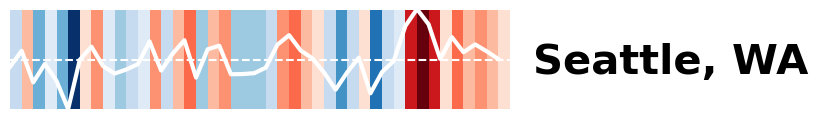

In [13]:
# Define the shape of each bar
rect_ll_y = df_annual.anomaly.min() # rectangle lower left y coordinate, minimum anomaly value
rect_height = np.abs(df_annual.anomaly.max()-df_annual.anomaly.min()) # rectangle height, range between min and max anomaly values
year_start = int(df_annual.year.min()) # year to start the plot x axis
year_end = int(df_annual.year.max() + 1) # year to end the plot x axis

# create a collection with a rectangle for each year
col = PatchCollection([
    Rectangle((x, rect_ll_y), 1, rect_height)
    for x in range(year_start, year_end)
])

# Create the figure, assign the data, colormap and color limits and add it to the figure axes
fig = plt.figure(figsize=(5, 1))

# set up the axes
ax = fig.add_axes([0, 0, 1, 1])
ax.set_axis_off()

# set data, colormap and color limits
col.set_array(df_annual.anomaly) # use the anomaly data for the colormap
col.set_cmap(cmap) # apply our custom red/blue colormap colors
col.set_clim(-rect_height/2, rect_height/2) # set the limits of our colormap
ax.add_collection(col)

# plot anomaly graph
df_annual.plot(x='year', y='anomaly', linestyle='-',lw=3,color='w',ax=ax, legend=False)
# plot horizontal line at zero anomaly
ax.axhline(0, linestyle='--', color='w')
# plot a text label
ax.text(df.year.max()+3,-.4,'Seattle, WA', fontsize=30, fontweight='bold', color='k')

# Make sure the axes limits are correct and save the figure.
ax.set_ylim(-rect_height/2, rect_height/2) # set y axis limits to rectanlge height centered at zero
ax.set_xlim(year_start, year_end); # set x axes limits to start and end year

# save the figure
fig.savefig('warming-stripes-seattle.svg', bbox_inches='tight')